In [2]:
# Config Variables

# Define UCI Datasets to pull
# https://archive.ics.uci.edu/ml/datasets.php
uci_datasets = [1,9,10,16,60,87,89,92,162,165,183,186,189,211,242,244,270,275,291,294,300,320,332,368,374,381,390,409,464,471,477,492,519,544,547,560,563,565,597,601,713,849,851,857,880,890,925,942]

# List of file names provided in the R code from 2018 Half Ridge Paper
paper2018_datasets = [
    "house.world", "mortality", "cit.world", "prf.world", "bodyfat.world", 
    "car.world", "cloud", "dropout", "fat.world", "fuel.world", "glps",
    "homeless.world", "landrent.world", "mammal.world", "oxidants",
    "attractiveness.men", "attractiveness.women", "fish.fertility", 
    "oxygen", "ozone"
]

# Use label encoding or one hot encoding for categorical variables? values: 'label', 'onehot', 'none'
categorical_encoding = 'onehot'

# How to handle missing data? values: 'mean', 'median', 'mode', 'drop', 'zero', 'ffill', 'bfill', 'interpolate'
missing_data_handling = 'mean'

# Training set sizes to use (only training set sizes < 60% of total dataset size will be used)
training_set_sizes = [10, 40, 160, 610, 2560, 10240, 40960]

In [3]:
# Load necessary libraries and helper functions

# import dataset class
from helpers.model import Model

# import os and pickle
import os
import pickle
 
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import FuncFormatter
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

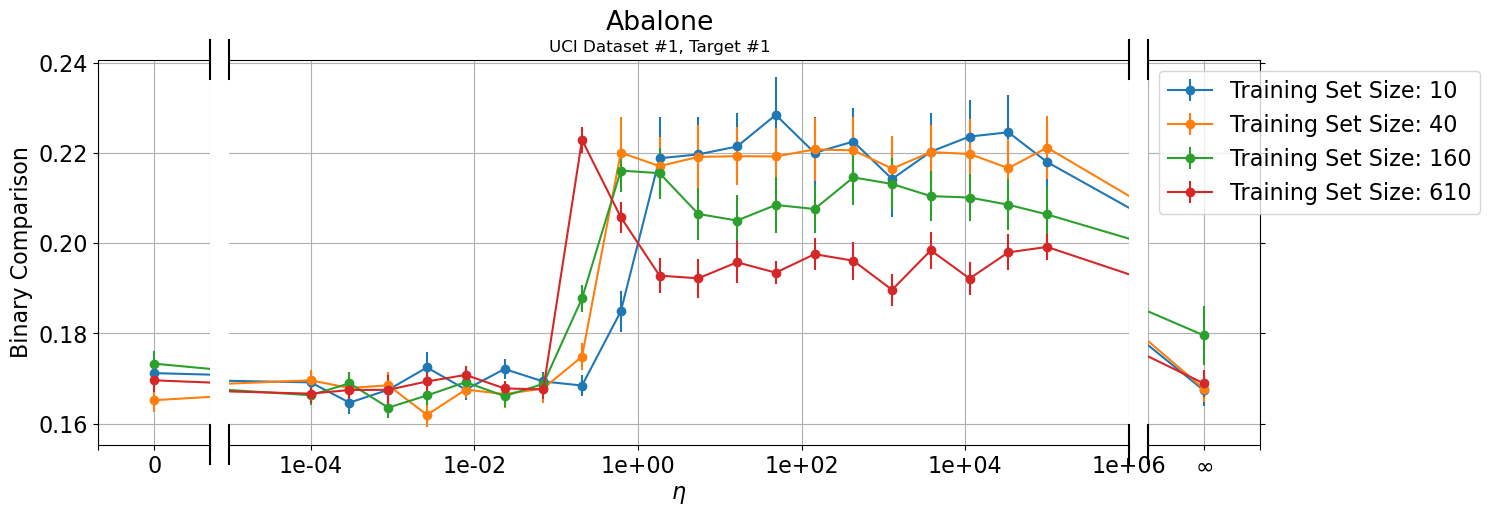

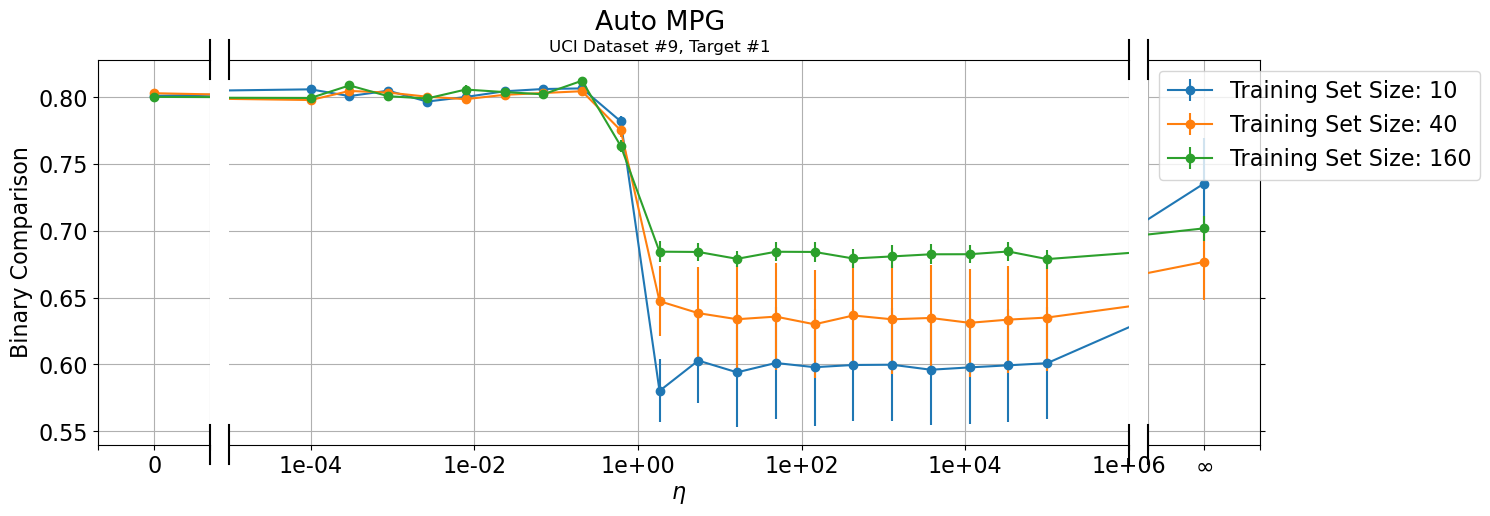

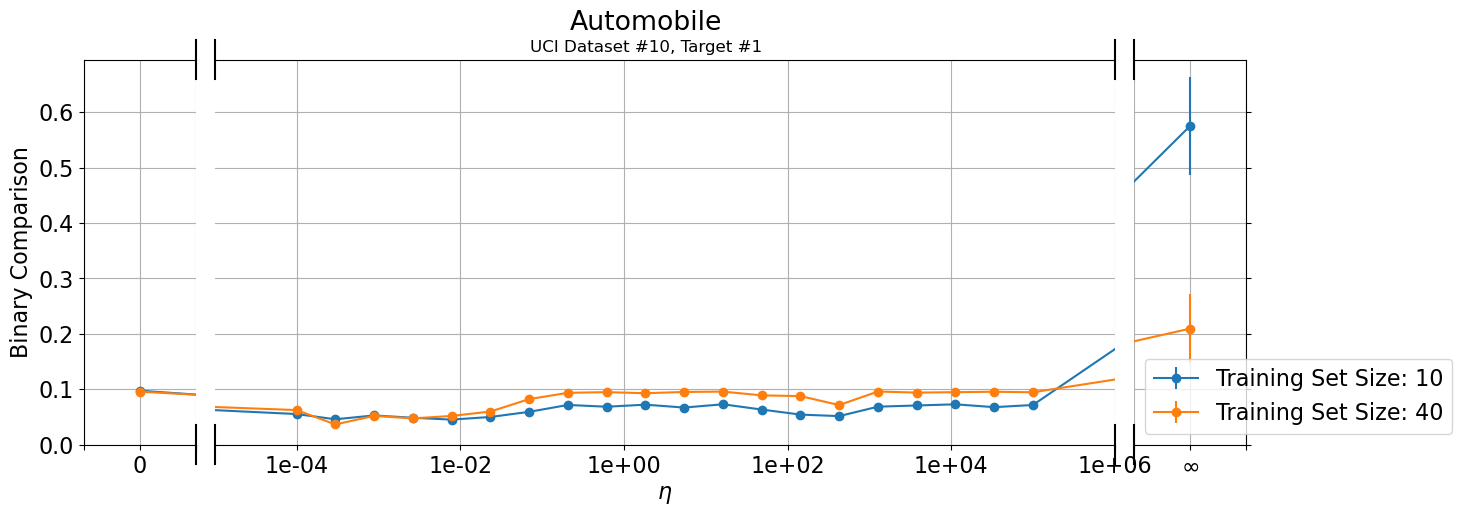

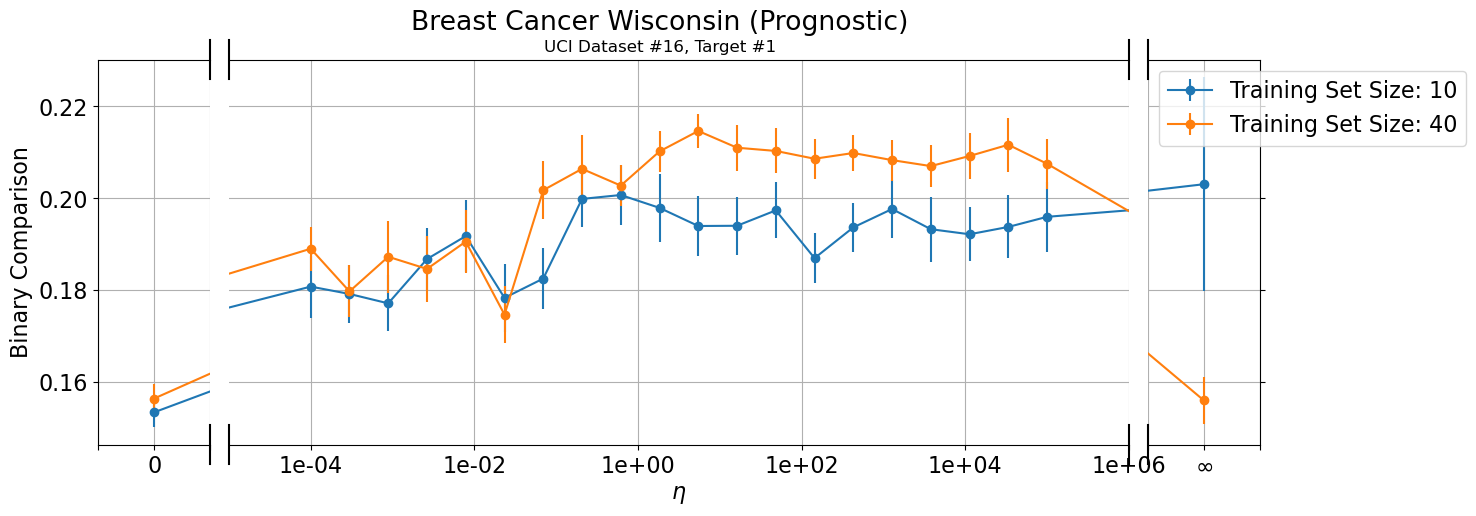

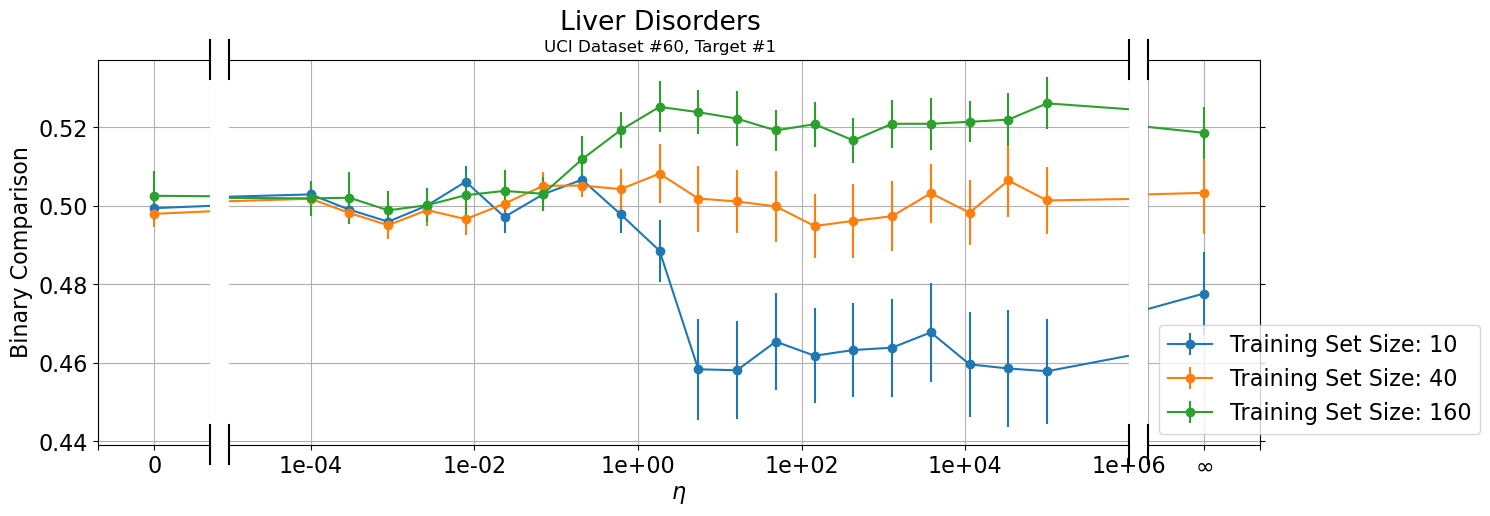

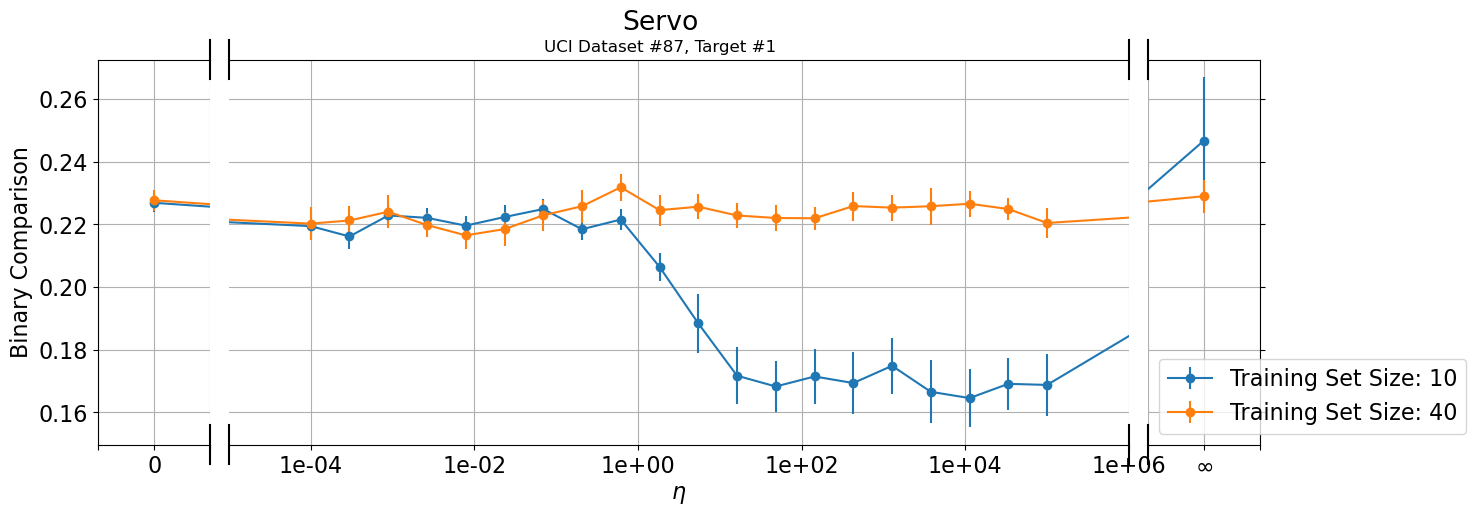

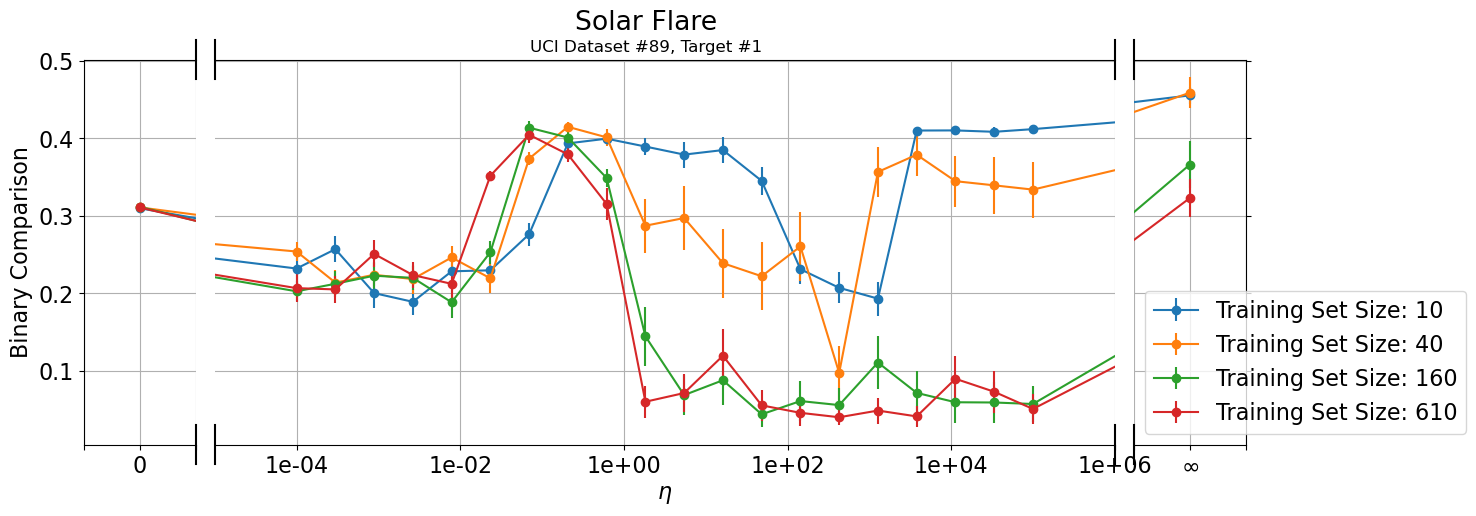

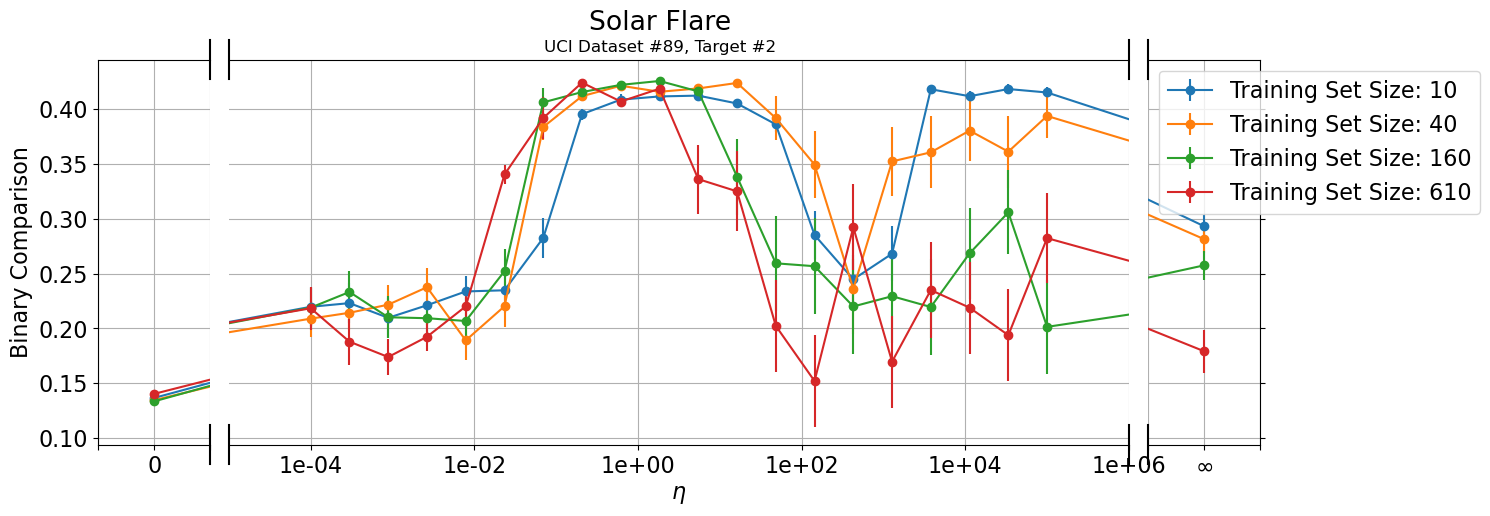

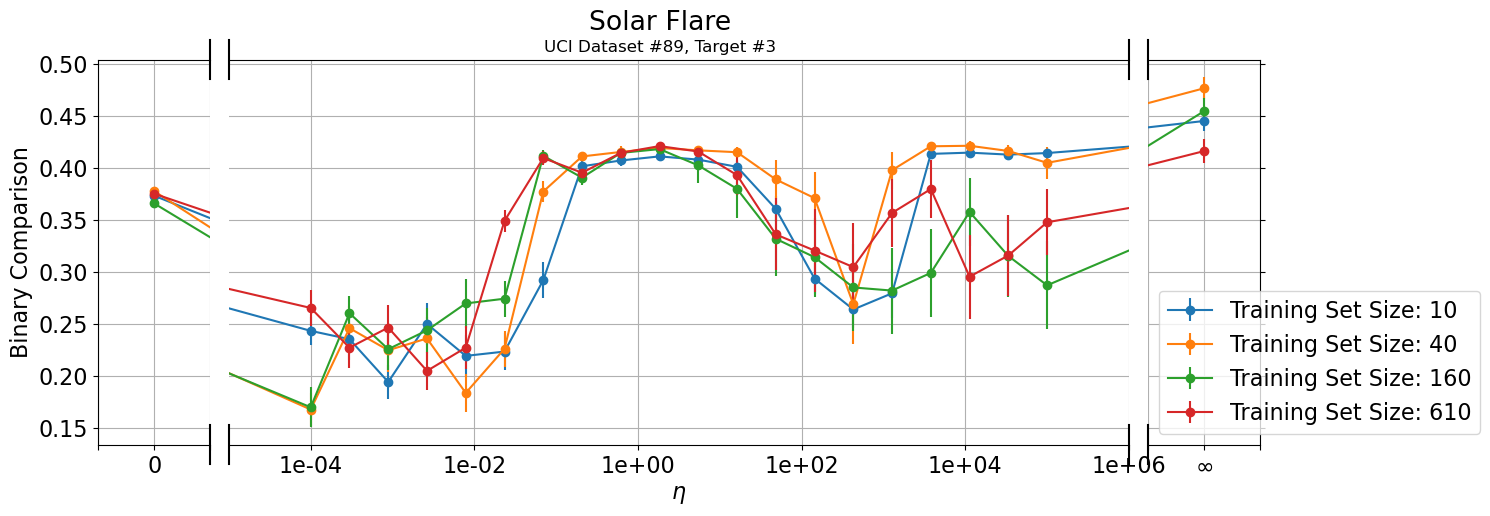

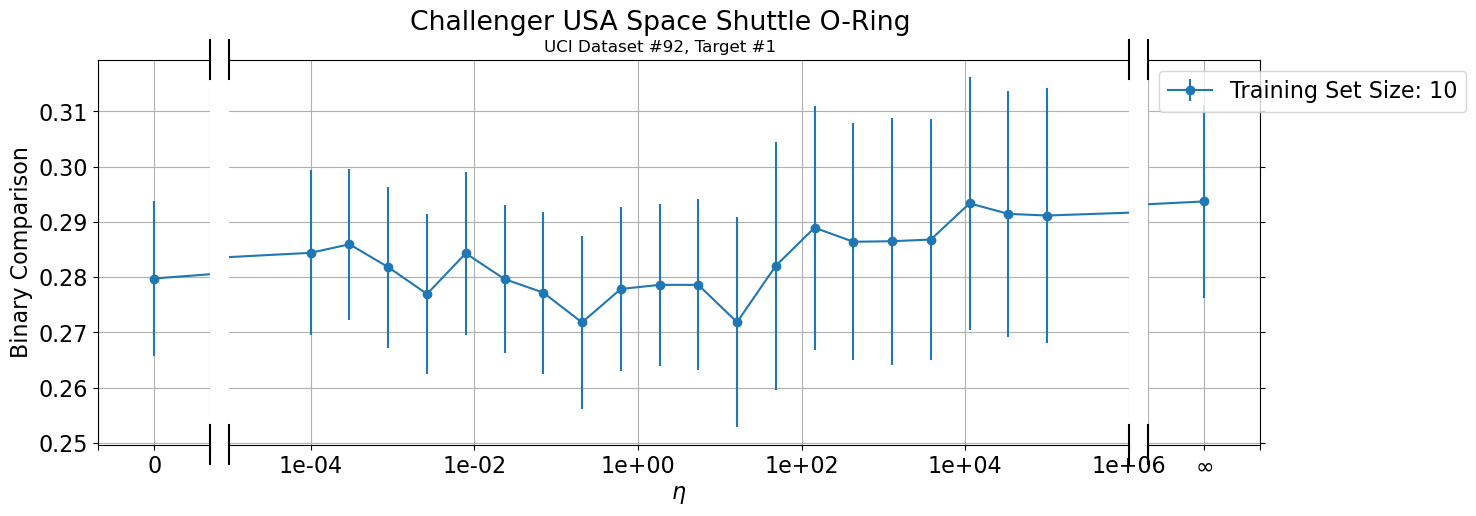

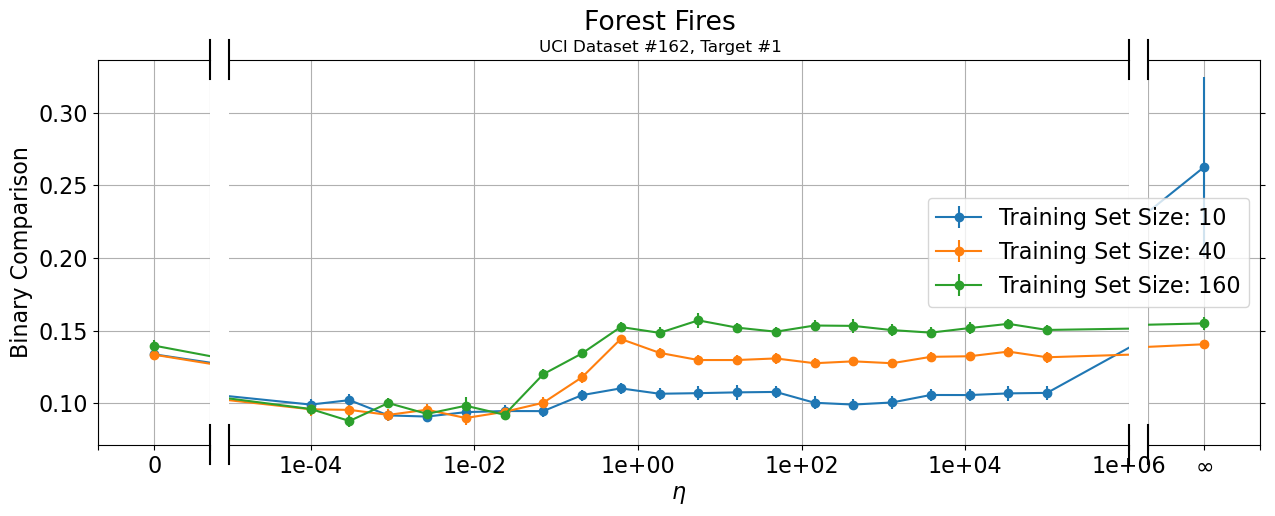

In [3]:
# Graph UCI Dataset Results

very_high_number = 10  # Replace this with an appropriate value for infinity (for graphing purposes only)
very_low_number = -10  # Replace this with an appropriate value for 0 (for graphing purposes only)

# Function to format the tick labels
def sci_notation(tick_val, pos):
    if tick_val == very_low_number:
        return r''
    elif tick_val == very_high_number:
        return r''
    else:
        return f"{10**tick_val:.0e}"
def inf_zero_formatter(tick_val, pos):
    if tick_val == very_low_number:
        return r'$0$'
    elif tick_val == very_high_number:
        return r'$\infty$'
    else:
        return f''

# Create a loop that iterates over datasets
for p_index, dataset in enumerate(uci_datasets):

    # Load the dataset
    model = Model()

    target = 0

    # iterate over the target (while the file exists)
    while os.path.isfile('model_results/ucirepo_' + str(dataset) + '_' + str(target) + '.csv'):

        model.import_from_file('uci_ml_datasets/ucirepo_' + str(dataset) + '_' + str(target) + '.csv')
        model.get_dataset_info(dataset)
        model.format_data(categorical_encoding, missing_data_handling)
        training_set_values = model.set_up_training_values(training_set_sizes, .6)

        # Load the binary comparisons
        with open('model_results/ucirepo_' + str(dataset) + '_' + str(target) + '.csv', 'rb') as file:
            binary_comparisons = pickle.load(file)

        # Create a figure with three subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5), gridspec_kw={'width_ratios': [.1, .8, .1]})
        fig.suptitle(f'{model.dataset_info.name}')
        fig.text(0.5, 0.92, f'UCI Dataset #{dataset}, Target #{target+1}', ha='center', va='top', fontsize=12)
        plt.subplots_adjust(wspace=0.05)

        # Loop over all_results and print a scatter plot with eta on the x-axis and the mean binary_comparisons on the y-axis for each training set size
        for training_set_value in training_set_values:
        
            # Get the etas and their corresponding means and errors
            etas = list(binary_comparisons[training_set_value].keys())
            binary_comparison_means = [np.mean(binary_comparisons[training_set_value][eta]) for eta in etas]
            binary_comparison_se = [np.std(binary_comparisons[training_set_value][eta]) / np.sqrt(len(binary_comparisons[training_set_value][eta])) for eta in etas]

            #print('Graphed Values')
            #print(f"Training Set Size: {training_set_value}")
            #print(binary_comparison_means)
            #print(binary_comparison_se)

            # Separate etas and their corresponding means and errors
            normal_etas = [eta for eta in etas if eta != 0 and eta != np.inf]
            log_normal_etas = np.log10(normal_etas)
            normal_means = [binary_comparison_means[i] for i, eta in enumerate(etas) if eta != 0 and eta != np.inf]
            normal_se = [binary_comparison_se[i] for i, eta in enumerate(etas) if eta != 0 and eta != np.inf]

            # Insert eta=0 and eta=np.inf into the lists with their positions
            if 0 in etas:
                zero_idx = etas.index(0)
                log_normal_etas = np.insert(log_normal_etas, 0, very_low_number)
                normal_means.insert(0, binary_comparison_means[zero_idx])
                normal_se.insert(0, binary_comparison_se[zero_idx])
            if np.inf in etas:
                inf_idx = etas.index(np.inf)
                log_normal_etas = np.append(log_normal_etas, very_high_number)
                normal_means.append(binary_comparison_means[inf_idx])
                normal_se.append(binary_comparison_se[inf_idx])

            # Plot the results for normal etas including eta=0 and eta=inf
            ax1.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")
            ax2.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")
            ax3.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")

        # Set axis limits and labels
        ax1.set_xlim(left=very_low_number-1, right=very_low_number+1)  # Adjust as needed to create space around 0
        ax2.set_xlim(left=log_normal_etas[1]-1, right=log_normal_etas[-2]+1)  # Adjust as needed to create space around infinity
        ax3.set_xlim(left=very_high_number-1, right=very_high_number+1)  # Adjust as needed to create space around infinity
        ax2.set_xlabel(r'$\eta$')
        ax1.set_ylabel('Binary Comparison')
        ax1.grid(True)
        ax2.grid(True)
        ax3.grid(True)
        ax3.legend()
        
        # Use the custom formatter for the x-axis
        ax1.xaxis.set_major_formatter(FuncFormatter(inf_zero_formatter))
        ax2.xaxis.set_major_formatter(FuncFormatter(sci_notation))
        ax3.xaxis.set_major_formatter(FuncFormatter(inf_zero_formatter))

        # Hide the right spines of ax1 and the left spines of ax2
        ax1.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax3.spines['left'].set_visible(False)
        ax1.yaxis.tick_left()
        ax2.tick_params(left = False) 
        ax3.yaxis.tick_right()

        # Draw small vertical lines to indicate the break
        line_length = 0.05  # Length of the vertical lines

        # Top and bottom lines at the right edge of ax1
        ax1.plot([1, 1], [1 - line_length, 1 + line_length], transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot([1, 1], [0 - line_length, line_length], transform=ax1.transAxes, color='k', clip_on=False)

        # Top and bottom lines at the left edge of ax2
        ax2.plot([0, 0], [1 - line_length, 1 + line_length], transform=ax2.transAxes, color='k', clip_on=False)
        ax2.plot([0, 0], [0 - line_length, line_length], transform=ax2.transAxes, color='k', clip_on=False)

        # Top and bottom lines at the right edge of ax2
        ax2.plot([1, 1], [1 - line_length, 1 + line_length], transform=ax2.transAxes, color='k', clip_on=False)
        ax2.plot([1, 1], [0 - line_length, line_length], transform=ax2.transAxes, color='k', clip_on=False)

        # Top and bottom lines at the left edge of ax3
        ax3.plot([0, 0], [1 - line_length, 1 + line_length], transform=ax3.transAxes, color='k', clip_on=False)
        ax3.plot([0, 0], [0 - line_length, line_length], transform=ax3.transAxes, color='k', clip_on=False)

        plt.show()

        # Increment the target
        target += 1

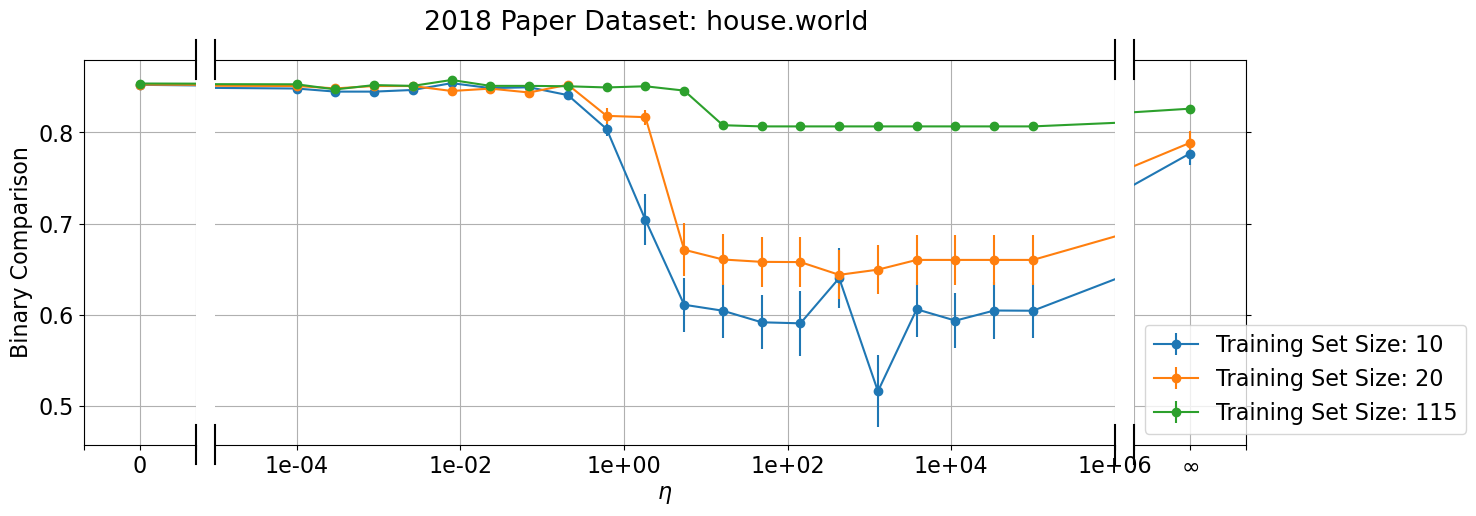

In [16]:
# Graph 2018 Paper Results

training_set_sizes = [10, 20, 115] # Used for 2018 paper

very_high_number = 10  # Replace this with an appropriate value for infinity (for graphing purposes only)
very_low_number = -10  # Replace this with an appropriate value for 0 (for graphing purposes only)

# Function to format the tick labels
def sci_notation(tick_val, pos):
    if tick_val == very_low_number:
        return r''
    elif tick_val == very_high_number:
        return r''
    else:
        return f"{10**tick_val:.0e}"
def inf_zero_formatter(tick_val, pos):
    if tick_val == very_low_number:
        return r'$0$'
    elif tick_val == very_high_number:
        return r'$\infty$'
    else:
        return f''

# Create a loop that iterates over datasets
for p_index, dataset in enumerate(paper2018_datasets):

    # Load the dataset
    model = Model()

    target = 0

    # iterate over the target (while the file exists)
    while os.path.isfile('model_results/2018paper_' + str(dataset) + '_' + str(target) + '.csv'):

        model.import_from_file('2018paper_datasets/2018paper_' + str(dataset) + '_' + str(target) + '.csv')
        model.format_data(categorical_encoding, missing_data_handling)
        model.create_paired_data()
        training_set_values = model.set_up_training_values(training_set_sizes, .6)

        # Load the binary comparisons
        with open('model_results/2018paper_' + str(dataset) + '_' + str(target) + '.csv', 'rb') as file:
            binary_comparisons = pickle.load(file)

        # Create a figure with three subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5), gridspec_kw={'width_ratios': [.1, .8, .1]})
        fig.suptitle(f'2018 Paper Dataset: {dataset}')
        plt.subplots_adjust(wspace=0.05)

        # Loop over all_results and print a scatter plot with eta on the x-axis and the mean binary_comparisons on the y-axis for each training set size
        for training_set_value in training_set_values:
        
            # Get the etas and their corresponding means and errors
            etas = list(binary_comparisons[training_set_value].keys())
            binary_comparison_means = [np.mean(binary_comparisons[training_set_value][eta]) for eta in etas]
            binary_comparison_se = [np.std(binary_comparisons[training_set_value][eta]) / np.sqrt(len(binary_comparisons[training_set_value][eta])) for eta in etas]

            #print('Graphed Values')
            #print(f"Training Set Size: {training_set_value}")
            #print(binary_comparison_means)
            #print(binary_comparison_se)

            # Separate etas and their corresponding means and errors
            normal_etas = [eta for eta in etas if eta != 0 and eta != np.inf]
            log_normal_etas = np.log10(normal_etas)
            normal_means = [binary_comparison_means[i] for i, eta in enumerate(etas) if eta != 0 and eta != np.inf]
            normal_se = [binary_comparison_se[i] for i, eta in enumerate(etas) if eta != 0 and eta != np.inf]

            # Insert eta=0 and eta=np.inf into the lists with their positions
            if 0 in etas:
                zero_idx = etas.index(0)
                log_normal_etas = np.insert(log_normal_etas, 0, very_low_number)
                normal_means.insert(0, binary_comparison_means[zero_idx])
                normal_se.insert(0, binary_comparison_se[zero_idx])
            if np.inf in etas:
                inf_idx = etas.index(np.inf)
                log_normal_etas = np.append(log_normal_etas, very_high_number)
                normal_means.append(binary_comparison_means[inf_idx])
                normal_se.append(binary_comparison_se[inf_idx])

            # Plot the results for normal etas including eta=0 and eta=inf
            ax1.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")
            ax2.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")
            ax3.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")

        # Set axis limits and labels
        ax1.set_xlim(left=very_low_number-1, right=very_low_number+1)  # Adjust as needed to create space around 0
        ax2.set_xlim(left=log_normal_etas[1]-1, right=log_normal_etas[-2]+1)  # Adjust as needed to create space around infinity
        ax3.set_xlim(left=very_high_number-1, right=very_high_number+1)  # Adjust as needed to create space around infinity
        ax2.set_xlabel(r'$\eta$')
        #ax2.set_xlabel(r'$\frac{1}{\eta^2}$')
        ax1.set_ylabel('Binary Comparison')
        ax1.grid(True)
        ax2.grid(True)
        ax3.grid(True)
        ax3.legend()
        
        # Use the custom formatter for the x-axis
        ax1.xaxis.set_major_formatter(FuncFormatter(inf_zero_formatter))
        ax2.xaxis.set_major_formatter(FuncFormatter(sci_notation))
        ax3.xaxis.set_major_formatter(FuncFormatter(inf_zero_formatter))

        # Hide the right spines of ax1 and the left spines of ax2
        ax1.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax3.spines['left'].set_visible(False)
        ax1.yaxis.tick_left()
        ax2.tick_params(left = False) 
        ax3.yaxis.tick_right()

        # Draw small vertical lines to indicate the break
        line_length = 0.05  # Length of the vertical lines

        # Top and bottom lines at the right edge of ax1
        ax1.plot([1, 1], [1 - line_length, 1 + line_length], transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot([1, 1], [0 - line_length, line_length], transform=ax1.transAxes, color='k', clip_on=False)

        # Top and bottom lines at the left edge of ax2
        ax2.plot([0, 0], [1 - line_length, 1 + line_length], transform=ax2.transAxes, color='k', clip_on=False)
        ax2.plot([0, 0], [0 - line_length, line_length], transform=ax2.transAxes, color='k', clip_on=False)

        # Top and bottom lines at the right edge of ax2
        ax2.plot([1, 1], [1 - line_length, 1 + line_length], transform=ax2.transAxes, color='k', clip_on=False)
        ax2.plot([1, 1], [0 - line_length, line_length], transform=ax2.transAxes, color='k', clip_on=False)

        # Top and bottom lines at the left edge of ax3
        ax3.plot([0, 0], [1 - line_length, 1 + line_length], transform=ax3.transAxes, color='k', clip_on=False)
        ax3.plot([0, 0], [0 - line_length, line_length], transform=ax3.transAxes, color='k', clip_on=False)

        plt.show()

        # Increment the target
        target += 1